In [50]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import matplotlib.pyplot as plt
from matplotlib import cm
import anacal
import astropy.table as astTable
import glob

import numpy as np
import lsst.geom as geom
from astropy.io import ascii as astascii
import anacal
import astropy.table as astTable
import fitsio
import xlens
from matplotlib.ticker import MaxNLocator

In [222]:
if False:
    full = astTable.Table.read("/work/xiangchong.li/superonionGW/code/hsc_final/HSC_S23B_Shapes/notebook/3_data/fwhm_var_table.fits")
    full.sort(["index"])
    full2 = astTable.Table.read("/lustre/work/xiangchong.li/work/hsc_s23b_data/catalogs/tracts_fdfc_v1_trim6.fits")
    full2["fwhm"] = full["fwhm"]
    full2["var"] = full["var"]
    full2.write("/lustre/work/xiangchong.li/work/hsc_s23b_data/catalogs/tracts_fdfc_v1_trim6.fits", overwrite=True)

(array([   5.,   15.,   41.,   42.,   59.,  163.,  241.,  219.,  245.,
         287.,  331.,  406.,  513.,  828., 1036., 1141., 1243., 1297.,
        1264., 1407., 1738., 1966., 2055., 2132., 2241., 2071., 2203.,
        2215., 2079., 1970., 1619., 1556., 1236., 1004.,  697.,  541.,
         416.,  288.,  221.,  155.,   86.,   61.,   50.,   38.,   27.,
          11.,    8.,    6.,    7.,    7.]),
 array([0.38359273, 0.39307325, 0.40255377, 0.41203429, 0.42151481,
        0.43099533, 0.44047585, 0.44995637, 0.45943689, 0.46891741,
        0.47839793, 0.48787845, 0.49735897, 0.50683949, 0.51632001,
        0.52580053, 0.53528105, 0.54476157, 0.55424209, 0.56372261,
        0.57320313, 0.58268365, 0.59216417, 0.60164469, 0.61112521,
        0.62060573, 0.63008625, 0.63956677, 0.64904729, 0.65852781,
        0.66800833, 0.67748885, 0.68696937, 0.69644989, 0.70593041,
        0.71541093, 0.72489145, 0.73437197, 0.74385249, 0.75333301,
        0.76281353, 0.77229405, 0.78177457, 0.79125509, 

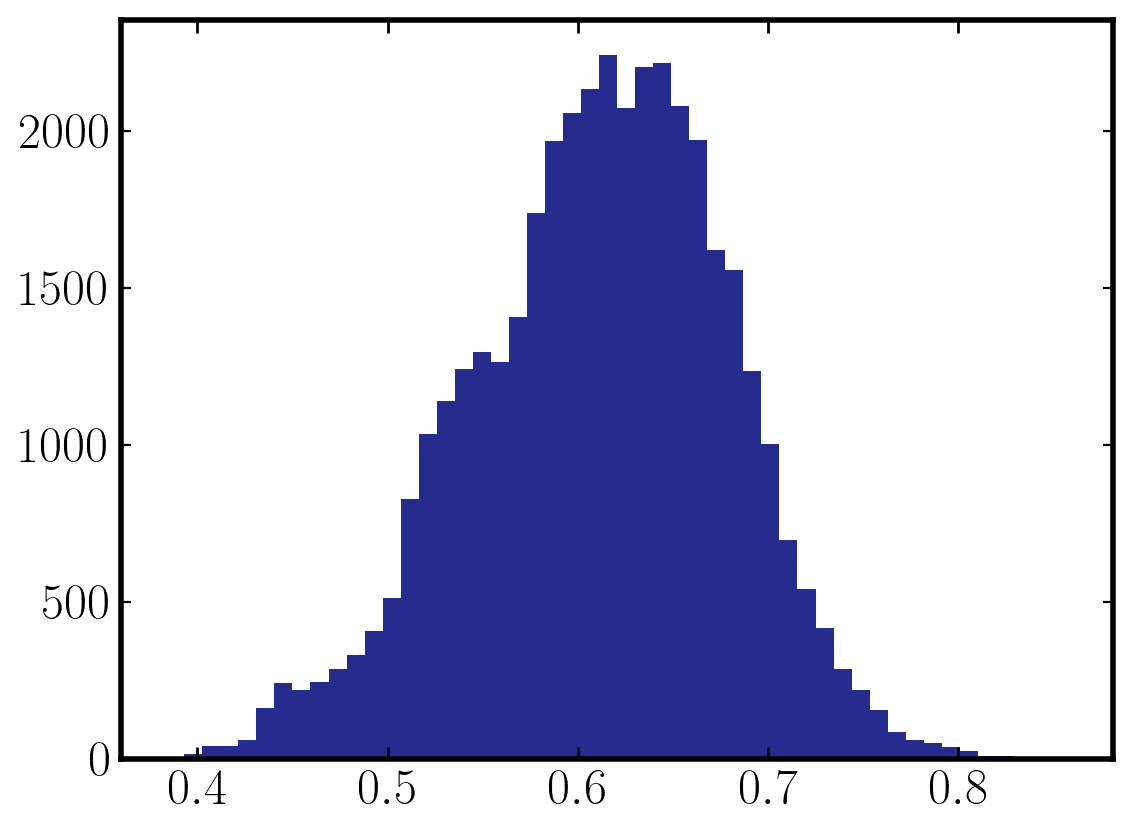

In [207]:
plt.hist(full["fwhm"], bins =50)

(array([   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    4.,
          40.,  231.,  608., 1207., 1619., 2186., 2392., 2476., 2527.,
        2362., 2340., 2221., 2309., 2280., 2108., 2020., 1827., 1509.,
        1373., 1134.,  993.,  743.,  617.,  526.,  358.,  298.,  238.,
         177.,  149.,  129.,   79.,   56.,   56.,   46.,   45.,   28.,
          27.,   20.,   17.,   10.,   11.]),
 array([0.    , 0.0002, 0.0004, 0.0006, 0.0008, 0.001 , 0.0012, 0.0014,
        0.0016, 0.0018, 0.002 , 0.0022, 0.0024, 0.0026, 0.0028, 0.003 ,
        0.0032, 0.0034, 0.0036, 0.0038, 0.004 , 0.0042, 0.0044, 0.0046,
        0.0048, 0.005 , 0.0052, 0.0054, 0.0056, 0.0058, 0.006 , 0.0062,
        0.0064, 0.0066, 0.0068, 0.007 , 0.0072, 0.0074, 0.0076, 0.0078,
        0.008 , 0.0082, 0.0084, 0.0086, 0.0088, 0.009 , 0.0092, 0.0094,
        0.0096, 0.0098, 0.01  ]),
 <BarContainer object of 50 artists>)

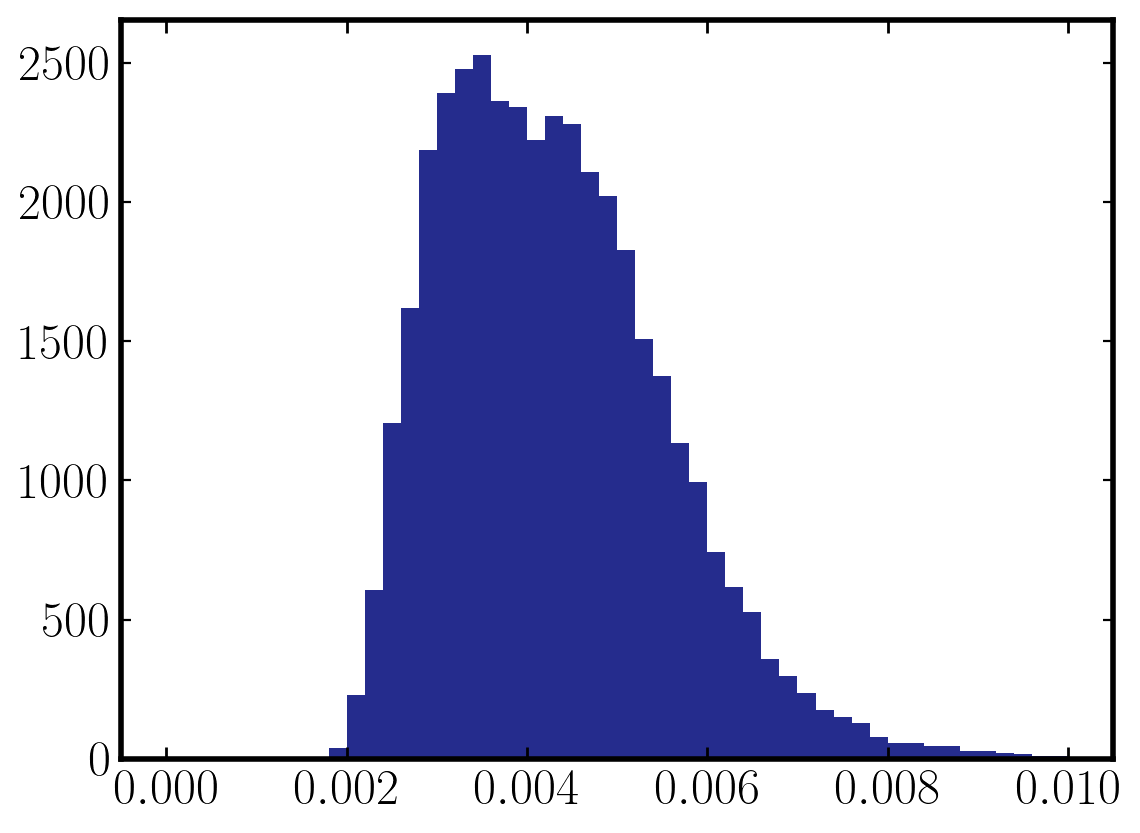

In [211]:
plt.hist(full["var"], bins =50, range=(0, 0.01))

(0.001, 0.02)

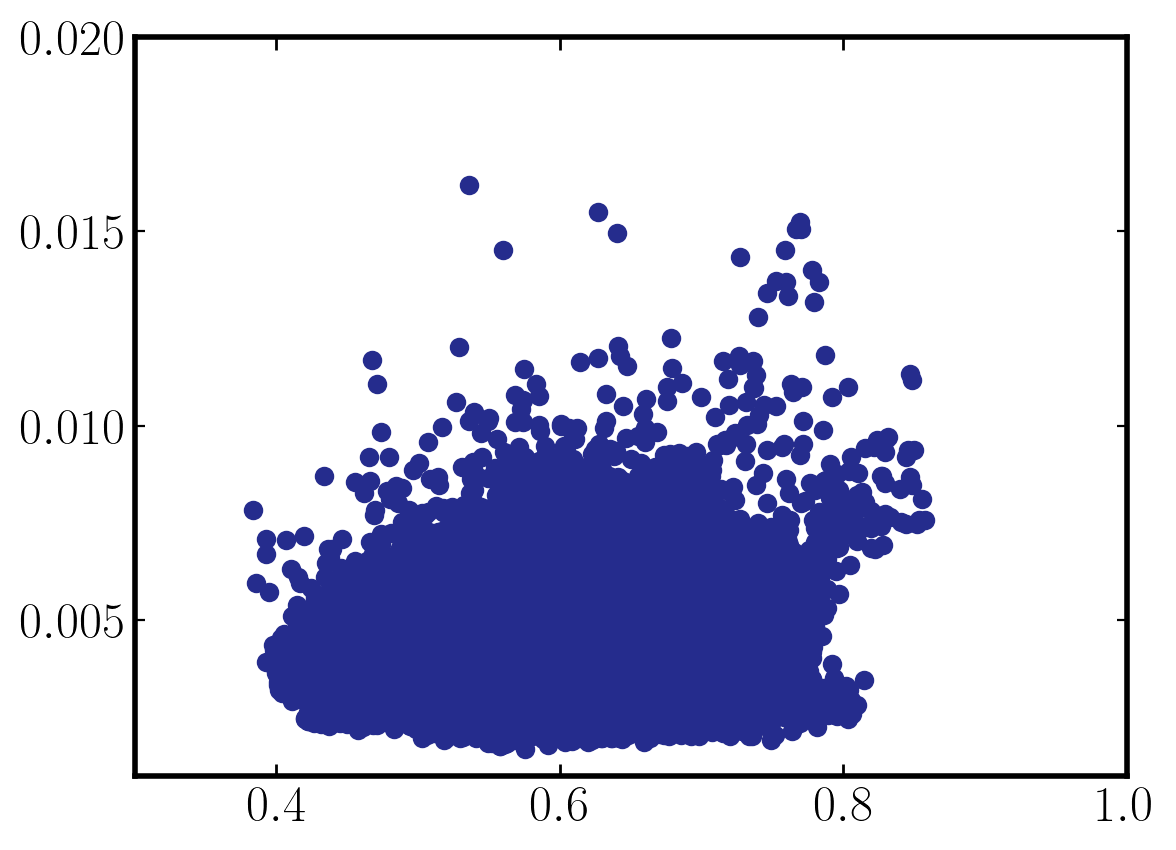

In [263]:
plt.scatter(full["fwhm"], full["var"])
plt.xlim(0.3, 1.0)
plt.ylim(0.001, 0.02)

In [277]:
a = astTable.Table()
a["tract"] = np.sort(np.unique(full["tract"]))
a.write("/work/xiangchong.li/superonionGW/code/hsc_final/HSC_S23B_Shapes/sql/tracts.csv")

In [271]:
# Load catalog
full = astTable.Table.read("/lustre/work/xiangchong.li/work/hsc_s23b_data/catalogs/tracts_fdfc_v1_trim6.fits")

# All keys to extract
keys = ["e1", "r1", "e2", "r2", "e1_4", "r1_4", "e2_4", "r2_4",
        "e1_s", "r1_s", "e2_s", "r2_s", "e1_v", "r1_v", "e2_v", "r2_v"]

# Initialize containers
data = {k: [] for k in keys}

# Loop through entries
for d in full:
    tid = d["tract"]
    patch_db = d["patch"]
    patch_x = patch_db // 100
    patch_y = patch_db % 100
    pid = patch_x + patch_y * 9

    fn = f"/lustre/work/xiangchong.li/work/hsc_s23b_data/catalogs/database/s23b-anacal/tracts/{tid}/{pid}/leakage2.fits"
    if not os.path.isfile(fn):
        print(d, tid, pid)
        continue
    if (d["var"] > 8e-3) | (d["var"] < 2e-3):
        continue
    tab = fitsio.read(fn)
    for k in keys:
        data[k].append(np.asarray(tab[k]))

# Stack arrays
for k in keys:
    data[k] = np.vstack(data[k])

tract patch  field          ra               dec         index        fwhm                var         
----- ----- ------- ----------------- ------------------ ----- ------------------ --------------------
 9853   100 spring3 210.3121663569887 1.4870657990955534  3381 0.6108579832845437 0.003648663758453869 9853 1
tract patch  field          ra                dec         index        fwhm                 var         
----- ----- ------- ------------------ ------------------ ----- ------------------ ---------------------
 9572   805 spring1 151.84818359676333 0.9304124726813998  3613 0.6075310682729307 0.0030120941415307423 9572 53
tract patch  field          ra                 dec         index        fwhm                 var         
----- ----- ------- ------------------ ------------------- ----- ------------------ ---------------------
 9329   706 spring1 152.03258727640576 -0.3704325767142439  8948 0.5917872432429958 0.0032666012600301433 9329 61
tract patch  field          ra     

In [272]:
# Rename base keys by appending "_2"
for base in ["e1", "r1", "e2", "r2"]:
    data[f"{base}_2"] = data.pop(base)
suffixes = ["2", "4", "s", "v"]
ave = {}
std = {}

n_bootstraps = 100
n = data["e1_2"].shape[0]
indices = np.random.randint(0, n, size=(n_bootstraps, n))

for suffix in suffixes:
    e1 = data[f"e1_{suffix}"]
    r1 = data[f"r1_{suffix}"]
    e2 = data[f"e2_{suffix}"]
    r2 = data[f"r2_{suffix}"]

    up1 = np.sum(e1[indices], axis=1)
    down1 = np.sum(r1[indices], axis=1)
    up2 = np.sum(e2[indices], axis=1)
    down2 = np.sum(r2[indices], axis=1)

    std[f"std1_{suffix}"] = np.std(up1 / down1, axis=0)
    std[f"std2_{suffix}"] = np.std(up2 / down2, axis=0)

    ave[f"ave1_{suffix}"] = np.sum(e1, axis=0) / np.sum(r1, axis=0)
    ave[f"ave2_{suffix}"] = np.sum(e2, axis=0) / np.sum(r2, axis=0) 

[-0.01439115 -0.00010109] 0.0007067795165284944
[-0.02431387  0.00019846] 0.004136914619438121
[-0.01856935  0.00010188] 0.003885507414517636
[-5.92221413e-03  7.90383750e-05] 0.0022699664785641393
[ 0.00342915 -0.00191289] 0.000560664182168353
[ 0.00033309 -0.00018488] 0.001152268487451389
[-0.07984711  0.00024079] 0.053258400062525066
[ 0.0952599 -0.0002939] 0.04256098715039821


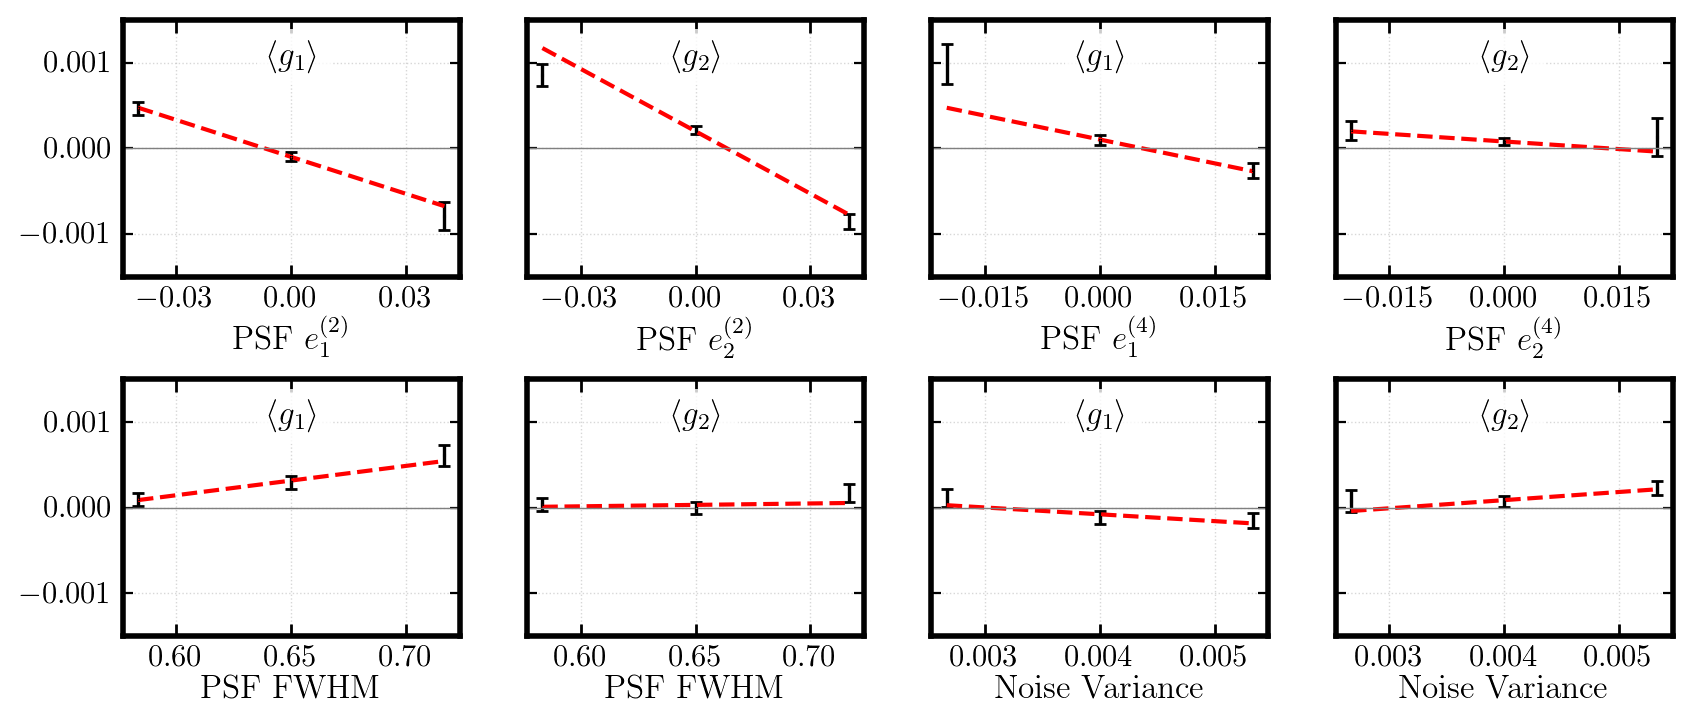

In [273]:
# Construct x_data
x_data = np.vstack([
    tab["e_psf_2"], tab["e_psf_2"],
    tab["e_psf_4"], tab["e_psf_4"],
    tab["size"],      tab["size"],
    tab["var"],       tab["var"]
])

# Construct y_data and y_errs from the ave/std dicts
pairs = [
    ("ave1_2", "std1_2"),
    ("ave2_2", "std2_2"),
    ("ave1_4", "std1_4"),
    ("ave2_4", "std2_4"),
    ("ave1_s", "std1_s"),
    ("ave2_s", "std2_s"),
    ("ave1_v", "std1_v"),
    ("ave2_v", "std2_v")
]

y_data = np.vstack([ave[k] for k, _ in pairs])
y_errs = np.vstack([std[k] for _, k in pairs])

# Prepare figure
fig, axes = plt.subplots(2, 4, figsize=(10, 4), sharey='row', gridspec_kw={'hspace': 0.4})
axes = axes.flatten()

# Titles and X-labels
titles = [r'$\langle g_1 \rangle$', r'$\langle g_2 \rangle$'] * 4
xlabels = [
    r'PSF $e_1^{(2)}$', r'PSF $e_2^{(2)}$',
    r'PSF $e_1^{(4)}$', r'PSF $e_2^{(4)}$',
    'PSF FWHM', 'PSF FWHM',
    'Noise Variance', 'Noise Variance'
]

# Loop over panels
for i, ax in enumerate(axes):
    x = x_data[i]
    y = y_data[i]
    yerr = y_errs[i]

    ax.errorbar(x, y, yerr=yerr, fmt='s', color='black', markersize=0.1, capsize=2, linewidth=1.2)

    # Linear fit with inverse variance weighting
    coeffs, cov = np.polyfit(x, y, deg=1, w=1. / yerr**2, cov=True)
    print(coeffs, np.sqrt(cov[0, 0]))

    xfit = np.linspace(np.min(x), np.max(x), 100)
    ax.plot(xfit, np.polyval(coeffs, xfit), 'r--', linewidth=1.5)

    ax.axhline(0, color='gray', linewidth=0.5)
    ax.grid(True, linestyle=':', linewidth=0.5)
    ax.xaxis.set_major_locator(MaxNLocator(nbins=3))
    ax.yaxis.set_major_locator(MaxNLocator(nbins=3))

    ax.text(0.43, 0.92, titles[i], transform=ax.transAxes,
            fontsize=12, va='top', ha='left',
            bbox=dict(facecolor='white', edgecolor='none', alpha=0.8))

    ax.set_xlabel(xlabels[i], fontsize=12, labelpad=1)
    ax.set_ylim(-0.0015, 0.0015)
    ax.tick_params(labelsize=11)

plt.show()

In [159]:
a = fitsio.read("/lustre/work/xiangchong.li/work/hsc_s23b_data/catalogs/database/s23b-stars/stars.fits")
e1p, e2p = xlens.catalog.basic.get_psf_ellip(a)
e1s, e2s = xlens.catalog.basic.get_sdss_ellip(a)

In [119]:
msk = (~np.isnan(e1p)) & (~np.isnan(e1s))
e1p = e1p[msk]
e1s = e1s[msk]

msk = (~np.isnan(e2p)) & (~np.isnan(e2s))
e2p = e2p[msk]
e2s = e2s[msk]

plt.scatter(e1p, e1p - e1s)
print(np.corrcoef(e1p, e1p - e1s)[0, 1])
print(np.corrcoef(e2p, e2p - e2s)[0, 1])

0.017252969282838145

0.02386990581944005

In [160]:
fwhm = xlens.catalog.basic.get_psf_size(a)

(array([ 12281.,  14654.,  19814.,  29240.,  43071.,  53490.,  60469.,
         68551.,  76114.,  81717.,  95094., 111898., 140438., 174413.,
        205193., 225703., 240782., 257293., 268899., 284261., 304903.,
        340355., 382244., 404201., 420670., 428741., 431028., 414703.,
        407235., 405180., 395729., 373164., 347080., 317368., 280848.,
        254143., 224363., 194020., 164556., 142223., 122692., 102396.,
         84010.,  68979.,  56405.,  48933.,  38584.,  34574.,  30565.,
         25461.]),
 array([0.40000001, 0.40799999, 0.41600001, 0.42399999, 0.43200001,
        0.44      , 0.44800001, 0.456     , 0.46399999, 0.472     ,
        0.47999999, 0.48800001, 0.49599999, 0.50400001, 0.51200002,
        0.51999998, 0.528     , 0.53600001, 0.54400003, 0.55199999,
        0.56      , 0.56800002, 0.57599998, 0.58399999, 0.59200001,
        0.60000002, 0.60799998, 0.616     , 0.62400001, 0.63200003,
        0.63999999, 0.648     , 0.65600002, 0.66399997, 0.67199999,
        

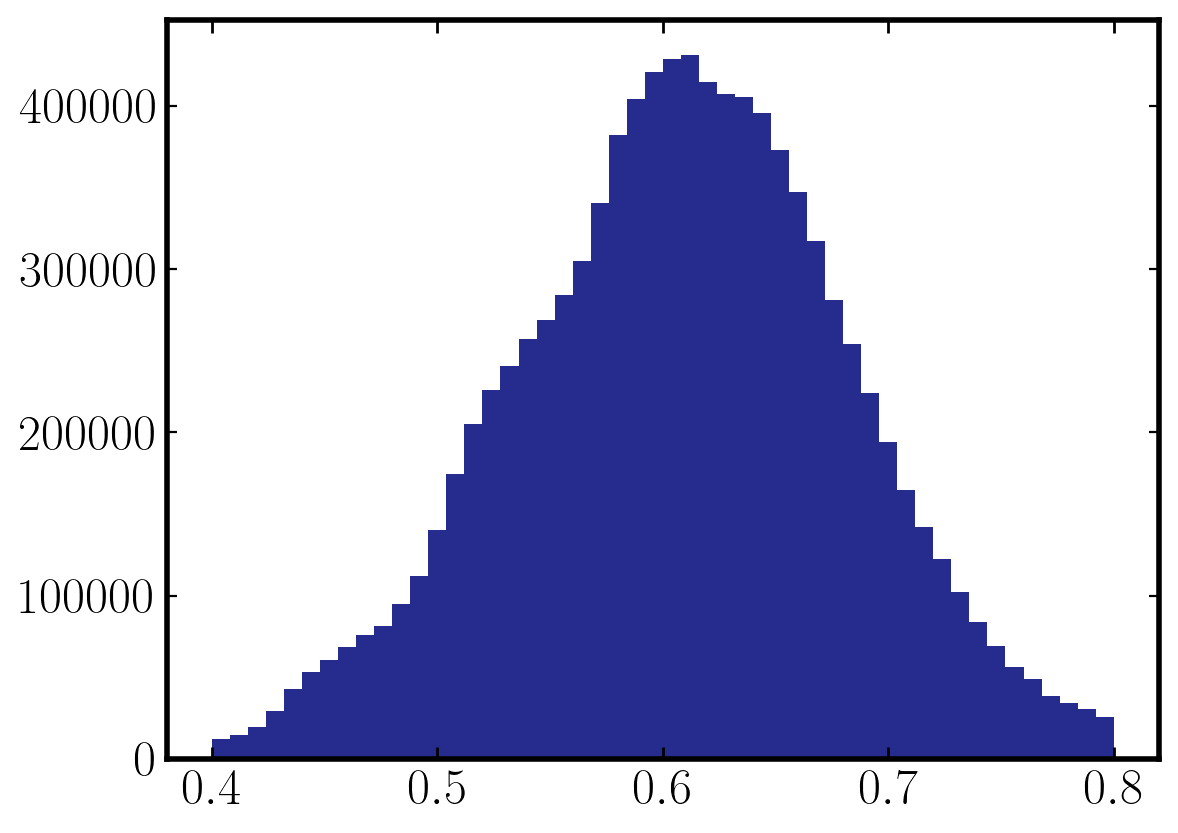

In [163]:
plt.hist(fwhm, bins=50, range=(0.4, 0.8))

In [182]:
import lsst.afw.table as afwtable
tract_id = 10041
patch_id = 2
cat_dir = "/lustre/HSC_DR/hsc_ssp/dr4/s23b/data/s23b_wide/unified/deepCoadd_meas"
band = "i"
files = glob.glob(os.path.join(cat_dir, f"{tract_id}/{patch_id}/{band}/*"))
cat =  afwtable.SourceCatalog.readFits(files[0])

In [191]:
full = fitsio.read("/lustre/work/xiangchong.li/work/hsc_s23b_data/catalogs/tracts_fdfc_v1_trim2_sim.fits")

In [199]:
for tt in np.unique(full['tract']):
    print(f"wget -r -np -nH --cut-dirs=6 --reject 'index.html*' https://hscdata.mtk.nao.ac.jp/hsc_ssp/dr4/s23b/data/s23b_wide/unified/deepCoadd_meas/{tt}/ &&")
    

wget -r -np -nH --cut-dirs=6 --reject 'index.html*' https://hscdata.mtk.nao.ac.jp/hsc_ssp/dr4/s23b/data/s23b_wide/unified/deepCoadd_meas/8279/ &&
wget -r -np -nH --cut-dirs=6 --reject 'index.html*' https://hscdata.mtk.nao.ac.jp/hsc_ssp/dr4/s23b/data/s23b_wide/unified/deepCoadd_meas/8280/ &&
wget -r -np -nH --cut-dirs=6 --reject 'index.html*' https://hscdata.mtk.nao.ac.jp/hsc_ssp/dr4/s23b/data/s23b_wide/unified/deepCoadd_meas/8281/ &&
wget -r -np -nH --cut-dirs=6 --reject 'index.html*' https://hscdata.mtk.nao.ac.jp/hsc_ssp/dr4/s23b/data/s23b_wide/unified/deepCoadd_meas/8282/ &&
wget -r -np -nH --cut-dirs=6 --reject 'index.html*' https://hscdata.mtk.nao.ac.jp/hsc_ssp/dr4/s23b/data/s23b_wide/unified/deepCoadd_meas/8283/ &&
wget -r -np -nH --cut-dirs=6 --reject 'index.html*' https://hscdata.mtk.nao.ac.jp/hsc_ssp/dr4/s23b/data/s23b_wide/unified/deepCoadd_meas/8284/ &&
wget -r -np -nH --cut-dirs=6 --reject 'index.html*' https://hscdata.mtk.nao.ac.jp/hsc_ssp/dr4/s23b/data/s23b_wide/unified/de